In [373]:
import geopandas as gp
import matplotlib
import pulp

In [374]:
data_frame = gp.read_file("<Replace with file path of land_parcels.shp>")
print(data_frame.head())

DataSourceError: /home/shipi/take_home/land_parcels.shp: No such file or directory

In [349]:
num_polygons = len(data_frame)
print(f"Number of polygons : {num_polygons}")

Number of polygons : 100


In [350]:
carbon_range = list((float(data_frame["carbon_sto"].min()), float(data_frame["carbon_sto"].max())))
print(f"The Range of Carbon_store : {carbon_range}")
cost_range = list((float(data_frame["cost"].min()), float(data_frame["cost"].max())))
print(f"The Range of Cost : {cost_range}")

The Range of Carbon_store : [10.036534572755878, 99.8608996768998]
The Range of Cost : [524.9516816211429, 4982.434015347925]


In [351]:
data_frame = data_frame.to_crs(epsg=3347)
print(f"The new projected coordinate system : {data_frame.crs}") # performing this check to see if the coordinate system has been modified to EPSG:3347

The new projected coordinate system : EPSG:3347


In [352]:
data_frame["area"] = data_frame.geometry.area
data_frame["area"] = data_frame["area"] / 1000000 # dividing by 1000000 to convert the units from m^2 to km^2
print(data_frame.head())

   parcel_id  carbon_sto         cost  \
0          0   57.050444  4706.178160   
1          1   28.383328  3722.863104   
2          2   31.481736  2281.036311   
3          3   70.452120  1849.986859   
4          4   38.455948  3883.390216   

                                            geometry        area  
0  POLYGON ((5968784.529 1435666.343, 5969808.7 1...  100.449939  
1  POLYGON ((5976843.926 1432838.093, 5978090.708...   86.099804  
2  POLYGON ((5986286.233 1435476.847, 5984060.72 ...   63.284145  
3  POLYGON ((5991054.366 1436300, 5993800.437 144...   95.908805  
4  POLYGON ((5997973.627 1432853.351, 6001629.132...  123.674383  


In [353]:
area_description = data_frame["area"].describe()
print(area_description)
min_area = area_description["min"]
avg_area = area_description["mean"]
max_area = area_description["max"]
print(f"The Minimum Area : {min_area}")
print(f"The Average Area : {avg_area}")
print(f"The Maximum Area : {max_area}")

count    100.000000
mean      80.540033
std       19.157155
min       37.378247
25%       67.342180
50%       78.752725
75%       92.329812
max      132.095543
Name: area, dtype: float64
The Minimum Area : 37.37824723691204
The Average Area : 80.54003288468249
The Maximum Area : 132.0955428630858


In [354]:
data_filtered = data_frame[((data_frame["area"] - np.mean(data_frame["area"])) / np.std(data_frame["area"]) <= 3)]
num_outliers = num_polygons - len(data_filtered) # this is the count for the number of outliers removed from the data frame
print(num_outliers)

0


In [355]:
adjacency_lst = {}

for i in data_filtered.iterrows():
    idx = i[0]
    polygon_geom = i[1].geometry
    neighbors = data_filtered[data_filtered.geometry.touches(polygon_geom) & (data_filtered.index != idx)].index.tolist()
    adjacency_lst[idx] = neighbors


In [356]:
# Lets initialise some quantities which we will be needing to solve this problem
total_budget = 0.5 * data_filtered["cost"].sum()

total_minimum_area = 0.25 * data_filtered["area"].sum()

In [357]:
to_solve = LpProblem("Maximizing Carbon store", LpMaximize)

/home/shipi/polygon_proj/polygon/lib/python3.12/site-packages/pulp/pulp.py:1423: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [358]:
poly_vars = {idx: LpVariable(f"polygon_{idx}", cat="Binary") for idx in data_filtered.index}

In [359]:
to_solve += lpSum(data_filtered.loc[idx, "carbon_sto"] * poly_vars[idx] for idx in data_filtered.index)

In [360]:
to_solve += lpSum(data_filtered.loc[idx, "cost"] * poly_vars[idx] for idx in data_filtered.index) <= total_budget

In [361]:
for (idx, neighbors) in adjacency_lst.items():
    for neighbor in neighbors:
        if idx < neighbor:
            to_solve += poly_vars[idx] + poly_vars[neighbor] <= 1

In [362]:
to_solve += lpSum(data_filtered.loc[idx, "area"] * poly_vars[idx] for idx in data_filtered.index) >= total_minimum_area

In [363]:
to_solve.solve(pulp.PULP_CBC_CMD(timeLimit=600))

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/shipi/polygon_proj/polygon/lib/python3.12/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/ec47a83955ea4dedad2fd041476c3205-pulp.mps -max -sec 600 -timeMode elapsed -branch -printingOptions all -solution /tmp/ec47a83955ea4dedad2fd041476c3205-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 349 COLUMNS
At line 1534 RHS
At line 1879 BOUNDS
At line 1980 ENDATA
Problem MODEL has 344 rows, 100 columns and 884 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 600
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2802.76 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 205 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 200 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 103 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 78 stre

1

In [364]:
for idx in selected_polygons:
    for neighbor in adjacency_lst[idx]:
        if neighbor in selected_polygons:
            print(f"Error: {idx} and {neighbor} are adjacent but both selected!")
print((sum(data_filtered.loc[idx, "cost"] for idx in selected_polygons) <= total_budget) and (sum(data_filtered.loc[idx, "area"] for idx in selected_polygons) >= total_minimum_area))

True


In [365]:
selected_polygons = [idx for idx in data_filtered.index if poly_vars[idx].value() == 1]
total_selected_cost = sum(data_filtered.loc[idx, "cost"] for idx in selected_polygons)
total_carbon_store = sum(data_filtered.loc[idx, "carbon_sto"] for idx in selected_polygons)
print(f"The Selected polygons are : {selected_polygons}")
print(f"The Total Cost of the Selected Polygons : {total_selected_cost}")
print(f"The Total Carbon Store of the Selected Polygons : {total_carbon_store}")

The Selected polygons are : [0, 2, 6, 9, 14, 20, 22, 26, 29, 34, 40, 46, 49, 52, 54, 60, 67, 69, 73, 81, 85, 87, 93, 99]
The Total Cost of the Selected Polygons : 67793.17435924022
The Total Carbon Store of the Selected Polygons : 1857.4268690033723


In [366]:
# Now we will output the final summary

In [368]:
print(f"The Number of Polygons selected : {len(selected_polygons)}")
print(f"The Sum of Carbon_Store for the Selected Polygons : {total_carbon_store}")
print(f"The Total Cost is : {total_selected_cost} which is less than the Total Budget : {total_budget}")
print(f"Quirks : One of the quirks I observed is when attempting to filter out any outliers using IQR,\
was that the lower bound threshhold for the area seemed to go beyond the lower bound of the range. So I had to swap to Z scores instead")

The Number of Polygons selected : 24
The Sum of Carbon_Store for the Selected Polygons : 1857.4268690033723
The Total Cost is : 67793.17435924022 which is less than the Total Budget : 140963.08493486073
Quirks : One of the quirks I observed is when attempting to filter out any outliers using IQR,was that the lower bound threshhold for the area seemed to go beyond the lower bound of the range. So I had to swap to Z scores instead


<Axes: >

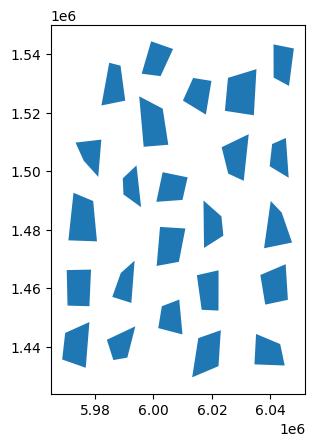

In [372]:
# Finally I shall include a plot of the selected polygons
data_selected = data_filtered.loc[selected_polygons]
data_selected.plot()

# 1.Introduction
This report summarizes the approach used to select a subset of land parcels that maximize total carbon storage while adhering to constraints on the budget and the overall area of the selected polygons while preventing adjacency of them.

# 2. Methodology

## a) Data Preprocessing

    . The land_parcels.shp file was loaded using geopandas.

    . The coordinate reference system (CRS) was reprojected to EPSG:3347 to ensure accurate area calculations.

    . Outliers in area were removed by comparing it's Z score(In this dataset there seem to be no outliers)

    . An Adjacency list was initialised to store lists of indices of polygons that share an edge with the current polygon.

## b) Optimization Initialisation

    . Objective: To Maximize total carbon_store.
    
    . Constraint 1 (Budget): Total cost ≤ 50% of the total cost after filtering out the outliers from the data_frame
    
    . Constraint 2 (No Adjacency): No two adjacent polygons can be selected (Here adjacency means having a common edge with another polygon).
    
    . Constraint 3 (Area): Total selected area ≥ 25% of total area after filtering out the outliers.

    . The optimization problem was then solved using PuLP’s CBC solver with a time limit of 600 seconds.(The time limit was set just as a precautionary measure)

## c) Challenges Encountered

    . Feasibility of Constraints : Some scalar multiples resulted in infeasible solutions. However adjusting the constraints improved feasibility
    
    . Handling Adjacency: Constructing an accurate adjacency hashmap required careful filtering to ensure only edge-sharing polygons were added.

## d) Final Results

    . After running the optimization model, the selected polygons were : [0, 2, 6, 9, 14, 20, 22, 26, 29, 34, 40, 46, 49, 52, 54, 60, 67, 69, 73, 81, 85, 87, 93, 99]

###  Solution Evaluation (These have been tested for within the code as well to ensure that the constraints are met)

        . Total Selected Cost: Within the budget limit.

        . Total Selected Carbon Storage: Maximized within constraints.

        . Adjacency Constraint Met: No two selected polygons share an edge.
        
        . Area Constraint Met: Total area exceeded the 25% requirement.
        
# Conclusion
The optimization model is successful in identifying an optimal subset of the land parcels so as to maximize carbon storage while maintaining constraints.